In [1]:
import os
import os.path
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

SCRIPT_PATH = os.path.join('..', 'scripts')
if SCRIPT_PATH not in sys.path:
    sys.path.append(SCRIPT_PATH)
from features import CATEGORICAL_FEATURES, VECTOR_FEATURES

In [2]:
NOTE = 'LightGBM-dart特徴量ミニマム（カテゴリ変数指定）'
notebook_name = '056'

N = 5
CV = f'Stratified-Kfold(K={N})'

OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1

056_submission.csv 056


In [3]:
def get_estimator(*,
                  categorical_features=None,
                  discrete_features=None,
                  vector_features=None,
                  features=None) -> Pipeline:

    clf = LGBMClassifier(random_state=SEED,
                         class_weight='balanced',
                         importance_type='gain',
                         boosting_type='dart',
                         n_jobs=-1,
                         n_estimators=300,
                         learning_rate=0.01)
    return Pipeline(
        steps=[
            ('estimator', clf)
         ]
    )

In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
CATEGORICAL_FEATURES

['batterID',
 'pitcherID',
 'Match',
 'isBatterHandLeft',
 'isPitcherHandLeft',
 'isBatterPitcher',
 'isBottom',
 'batterTeam',
 'pitcherTeam',
 'b1',
 'b2',
 'b3']

In [6]:
# Minimal features
minimal_features = [
    'inningNo',
    'totalPitchingCount',
    'B',
    'S',
    'O',
    'b1',
    'b2',
    'b3',
    'numRunners',
    'batterID',
    'pitcherID',
    'Match',
    'isBatterHandLeft',
    'isPitcherHandLeft',
    'isBatterPitcher',
    'isBottom',
    'batterTeam',
    'pitcherTeam',
]

categorical_features = [f for f in minimal_features if f in CATEGORICAL_FEATURES]
discrete_features = list(set(minimal_features) - set(categorical_features))
print(categorical_features)
print(discrete_features)

# Execute if categories should be one-hot style
# for c in categorical_features:
#     assert(train[c].isin(test[c]).sum() == train.shape[0])
#     assert(test[c].isin(train[c]).sum() == test.shape[0])

# train = pd.get_dummies(train, columns=categorical_features, drop_first=True)
# test = pd.get_dummies(test, columns=categorical_features, drop_first=True)

# assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
# assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())

# categorical_features_1hot = []
# for c in categorical_features:
#     categorical_features_1hot += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
# print(categorical_features_1hot)

# features = discrete_features + categorical_features_1hot
features = discrete_features + categorical_features

['b1', 'b2', 'b3', 'batterID', 'pitcherID', 'Match', 'isBatterHandLeft', 'isPitcherHandLeft', 'isBatterPitcher', 'isBottom', 'batterTeam', 'pitcherTeam']
['S', 'B', 'numRunners', 'totalPitchingCount', 'O', 'inningNo']


In [7]:
# features = [c for c in train.columns if c not in ('id', 'y')]
# assert(set(features) - set(test.columns.tolist()) == set())

In [8]:
# discrete_features = [f for f in features if f not in categorical_features]
# discrete_features

In [9]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )

    clf = get_estimator(features=features,
                        discrete_features=discrete_features,
                        categorical_features=categorical_features)
#     class_weight = compute_class_weight('balanced',
#                                         classes=np.sort(train.y.unique()),
#                                         y=y_train.values)
#     class_weight = dict(
#         zip(
#             np.sort(train.y.unique()),
#             class_weight
#         )
#     )
#     sample_weight = y_train.map(class_weight)
#     assert(sample_weight.isnull().sum() == 0)
    sample_weight = None
    clf.fit(X_train,
            y_train.values,
            estimator__sample_weight=sample_weight,
            estimator__categorical_feature=categorical_features)
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(test[features].copy())
    except AttributeError:
        infer = clf.decision_function(test[features].copy())
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf[-1].classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 1)**********
[[1444 1045  615  682  642  383   28  227]
 [ 461 1719  377  401  369  224   32  163]
 [ 239  325  844  368  332  166   15  104]
 [ 167  207  170  842  191   75    5   52]
 [  10   16   11   14  462   16    1   10]
 [   0    0    0    0    0  150    0    0]
 [   0    0    0    0    0    0    8    0]
 [   1    0    0    0    0    0    0   95]]

**********Confusion matrix for validation set (Fold 1)**********
[[253 297 196 175 175  96   9  66]
 [154 302 125 141  93  65   3  53]
 [ 92  98 114 112 105  44   1  33]
 [ 54  69  86 107  56  37   3  15]
 [ 21  29  25  27  22   6   2   3]
 [  9   6   1  10   5   5   0   1]
 [  2   0   0   1   0   0   0   0]
 [  3   8   6   3   4   0   0   0]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 2)**********
[[1408 1052  649  658  671  386   27  215]
 [ 512 1624  378  395  396  268   22  151]
 [ 247  332  863  364  334  156   11   86]
 [ 158  234  192  791  190   80    8   56]
 [  15   12   12   11  458   22    0   10]
 [   0    0    0    0    0  150    0    0]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 2)**********
[[233 319 191 169 179 100  14  62]
 [159 331 132 110 114  50   4  36]
 [ 74 116 106 137  88  42   5  31]
 [ 56  87  89 104  51  27   5   8]
 [ 19  24  32  24  22   4   1   9]
 [  7   7   7   7   5   4   0   0]
 [  1   1   0   0   0   0   0   0]
 [  5   6   5   4   2   2   0   0]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 3)**********
[[1448 1054  566  649  686  379   25  259]
 [ 473 1642  346  461  405  225   25  169]
 [ 275  334  742  399  369  159    9  107]
 [ 168  209  157  838  191   93    7   45]
 [  16   15   14    8  457   18    1   11]
 [   1    0    0    0    0  149    0    0]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 3)**********
[[282 313 156 166 155 112  15  68]
 [193 306 103 109  97  72  10  46]
 [ 81 106 115 129  92  37   4  34]
 [ 70  97  62  95  60  25   0  19]
 [ 26  24  17  33  22   6   0   7]
 [  5  12   5   8   4   1   0   2]
 [  1   0   0   0   0   1   0   0]
 [  4   4   4   3   4   2   0   3]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 4)**********
[[1370 1086  609  681  673  380   33  235]
 [ 509 1681  362  421  391  227   24  130]
 [ 218  346  793  416  353  151   14  103]
 [ 165  240  154  829  177   86   10   48]
 [   9   22    9   15  463   14    1    7]
 [   0    0    0    0    0  149    0    0]
 [   0    0    0    0    0    0    9    0]
 [   1    0    0    0    0    0    0   95]]

**********Confusion matrix for validation set (Fold 4)**********
[[235 315 166 207 183  99  10  51]
 [150 323 108 138 104  58  11  45]
 [ 76 113 114 118 113  41   3  20]
 [ 54  78  93  86  76  25   2  13]
 [ 19  23  21  40  14  12   2   4]
 [  8   5   3   9   6   6   1   0]
 [  1   1   0   0   0   0   0   0]
 [  5   6   6   0   4   1   0   2]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 5)**********
[[1397 1074  646  631  687  367   32  233]
 [ 467 1670  396  426  398  211   29  148]
 [ 245  356  838  343  352  149    8  103]
 [ 164  226  179  805  196   81    9   49]
 [  11   10   13    8  471   14    4    9]
 [   0    0    0    0    0  149    0    0]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 5)**********
[[267 311 182 176 162  96  10  62]
 [157 324 101 117 132  62   6  38]
 [ 77 114 102 133  98  40   1  33]
 [ 62  88  75  99  54  28   8  13]
 [ 21  24  17  38  19   9   0   7]
 [  4  11   5   7   8   2   0   1]
 [  0   1   0   1   0   0   0   0]
 [  4   4   4   5   5   0   0   2]]

Wall time: 1min 44s


In [10]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.337361,0.141164
std,0.002397,0.002663
min,0.334808,0.137911
25%,0.335039,0.139570
50%,0.337686,0.141123
75%,0.339088,0.142327
max,0.340186,0.144891


In [11]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,1,0,1
1,1,1,1,0,1
2,2,0,4,0,1
3,3,2,4,0,1
4,4,4,4,0,1
...,...,...,...,...,...
17126,9690,0,1,0,5
17129,9693,1,2,0,5
17130,16833,1,1,0,5
17133,9762,1,2,0,5


In [12]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,0.117851,0.122694,0.185312,0.116351,0.214182,0.063907,0.113554,0.066150,27446,1
1,0.143434,0.098799,0.315262,0.194110,0.070346,0.046390,0.085158,0.046500,113,1
2,0.163970,0.252806,0.239305,0.109541,0.055341,0.041060,0.096820,0.041158,4479,1
3,0.176359,0.218582,0.261758,0.145236,0.060343,0.046239,0.045134,0.046349,29080,1
4,0.159301,0.167065,0.208025,0.217552,0.081717,0.056796,0.054025,0.055519,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,0.147927,0.293729,0.149422,0.198896,0.066232,0.048082,0.047541,0.048170,24272,5
33804,0.113654,0.134940,0.217884,0.285002,0.089804,0.053075,0.052469,0.053172,29106,5
33805,0.107248,0.131406,0.218980,0.293695,0.089627,0.053080,0.052787,0.053177,20679,5
33806,0.269558,0.130384,0.176243,0.214008,0.070871,0.046436,0.045980,0.046521,25901,5


In [13]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,0.825605,0.910066,0.874913,0.872518,0.593031,0.313666,0.300981,0.309220
1,1,1.119021,1.238892,0.683485,0.690713,0.379499,0.339226,0.272235,0.276929
2,2,0.551017,0.508101,0.946305,1.060731,1.030406,0.341381,0.273114,0.288945
3,3,1.190601,1.387645,0.637844,0.715894,0.380074,0.231837,0.225103,0.231002
4,4,1.041420,1.390244,0.480559,0.614121,0.844064,0.210115,0.206522,0.212953
...,...,...,...,...,...,...,...,...,...
33803,33803,1.499416,0.564244,0.647151,0.659697,0.705951,0.300086,0.280609,0.342846
33804,33804,1.102882,1.123889,0.748955,0.850533,0.409808,0.254521,0.251037,0.258376
33805,33805,1.446195,1.087639,0.564224,0.738909,0.395556,0.256175,0.252288,0.259014
33806,33806,0.565180,0.697158,0.795313,0.718111,1.263192,0.324829,0.314849,0.321367


In [14]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,1
2,2,3
3,3,1
4,4,1
...,...,...
33803,33803,0
33804,33804,1
33805,33805,0
33806,33806,4


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.240919
1    0.383105
2    0.079449
3    0.214831
4    0.051408
5    0.018221
6    0.001597
7    0.010471
Name: y, dtype: float64

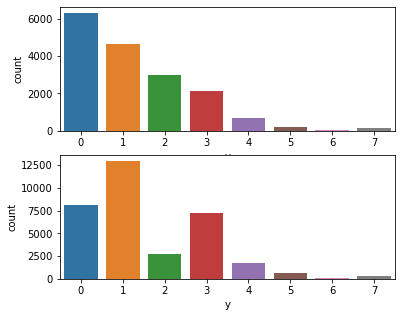

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [16]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [17]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.33736108904464146, 0.1411644248451776)

In [18]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"056_submission.csv","Stratified-Kfold(K=5)","0.337361","0.141164","","LightGBM-dart特徴量ミニマム（カテゴリ変数指定）"


In [19]:
%%time
for i, model in enumerate(models):
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(model, f)
        f.close()

Wall time: 2.17 s


In [20]:
%%time
imp_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        elif hasattr(final_estimator, 'feature_names_'):
            feature_names = final_estimator.feature_names_
        else:
            feature_names = final_estimator.get_booster().feature_names
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 17 ms


In [21]:
imp_df

,feature,importance,fold
0,S,84037.255639,1
1,B,76464.796343,1
2,numRunners,30217.874934,1
3,totalPitchingCount,96274.754577,1
4,O,97109.419656,1
...,...,...,...
13,isPitcherHandLeft,13644.676863,5
14,isBatterPitcher,7159.738334,5
15,isBottom,12308.629918,5
16,batterTeam,130.239880,5


In [22]:
%%time
coef_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'coef_'):
            coefficient = final_estimator.coef_
            coef_df_ = pd.DataFrame(coefficient, columns=features)
            coef_df_['fold'] = i + 1
            coef_df_['y'] = final_estimator.classes_
            coef_df = pd.concat([coef_df, coef_df_])
    except AttributeError:
        pass

if coef_df.shape[0] > 0:
    coef_df.to_csv(os.path.join(OUTPUT_DIR, 'coefficients.csv'), index=False)

Wall time: 0 ns


In [23]:
coef_df

""
